In [506]:
from helpers import *

import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler

from collections import OrderedDict
from itertools import product



linestyles = OrderedDict(
    [

     ('loosely dashed',      (0, (5, 20))),
     ('dashed',              (0, (3, 2))),
     ('densely dashed',      (0, (1, 3))),

    ])

# Data Processing

## Importing data

In [510]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='kaggle-data/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

print('circuits_raw_df', circuits_raw_df.columns)
print('constructors_raw_df', constructors_raw_df.columns)
print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
print('driver_standings_raw_df', driver_standings_raw_df.columns)
print('drivers_raw_df', drivers_raw_df.columns)
print('laptimes_raw_df', laptimes_raw_df.columns)
print('pitstops_raw_df', pitstops_raw_df.columns)
print('qualifying_raw_df', qualifying_raw_df.columns)
print('races_raw_df', races_raw_df.columns)
print('results_raw_df', results_raw_df.columns)
print('seasons_raw_df', seasons_raw_df.columns)
print('sprint_results', sprint_results.columns)
print('status_raw_df', status_raw_df.columns)

circuits_raw_df Index(['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng',
       'alt', 'url'],
      dtype='object')
constructors_raw_df Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
constructor_standings_raw_df Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')
driver_standings_raw_df Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins'],
      dtype='object')
drivers_raw_df Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'],
      dtype='object')
laptimes_raw_df Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds'], dtype='object')
pitstops_raw_df Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'],
      dtype='object')
qualifying_raw_df Index(['qualifyId', 'raceId', 'driverId',

## Merging data
Note: not filtering for drivers

In [509]:
# # Process drivers data set

# drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
# # Make name column
# drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
# drivers.drop(['forename','surname'], axis=1, inplace=True)

# driver_name_id_map = dict(zip(drivers['Name'], drivers['driverId']))
# def get_driverID(name):
#     return drivers.loc[drivers['Name']==name, 'driverId'].squeeze()

# driver_name_number_map = dict(zip(drivers['Name'], drivers['number']))
# def get_driver_number(name):
#     return drivers.loc[drivers['Name']==name, 'number'].squeeze()

# driver_names_of_interest = ['Max Verstappen',
#                            'Sergio Pérez',
#                            'Lewis Hamilton',
#                            'Fernando Alonso',
#                            'Charles Leclerc',
#                            'Lando Norris',
#                            'George Russell',
#                            'Oscar Piastri',
#                            'Lance Stroll',
#                            'Pierre Gasly',
#                            'Esteban Ocon',
#                            'Alexander Albon',
#                            'Nico Hülkenberg',
#                            'Valtteri Bottas',
#                            'Guanyu Zhou',
#                            'Yuki Tsunoda',
#                            'Kevin Magnussen',
#                            #'Liam Lawson',
#                            'Logan Sargeant',
#                            'Nyck de Vries',
#                            'Daniel Ricciardo']
# driver_ids_of_interest = [driver_name_id_map[name] for name in driver_names_of_interest]

# driver_numbers_of_interest = [driver_name_number_map[name] for name in driver_names_of_interest]


In [541]:
# Driver name
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)


# start with race results
# extend positionText labels (see Appendix)
results_raw_df['positionText'] = results_raw_df['positionText'].replace({'R':'Retired','D':'Disqualified','N':'not classified', 'E':'Excluded','W':'Withdrawn','F':'failed to qualify'})
# drop time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, and number (http://ergast.com/mrd/methods/results/)
races = results_raw_df.drop(['time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed','number'], axis=1)
races.drop(['positionOrder'], axis=1, inplace=True)
races['position'].fillna('NaN', inplace=True)
#display(races.isna().sum())
assert races.isna().sum().sum() == 0, 'there are null values'

# Get race data (ignoring qualifying data)
races_raw_df.rename(columns={'name':'Race'}, inplace=True)
prev_len = races.shape[0]
races = races.merge(races_raw_df[['raceId','Race','round','circuitId','date','url']], on='raceId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0

# Explode date
races['date'] = pd.to_datetime(races['date'])
races['Month'] = races['date'].dt.month
races['Year'] = races['date'].dt.year
#races.drop(['date'], axis=1, inplace=True)

# Filter year due to bad quality data in early years (multiple results reported for a driver in a race) -- see EDA for details
races = races[races['Year']>1964].reset_index(drop=True)
assert races.groupby(['raceId','driverId'])['position'].nunique().max()==1, 'there are multiple positions reported for a driver in a race'

# Merge with drivers
prev_len = races.shape[0]
races = races.merge(drivers[['driverId','Name']], on='driverId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Name'].isna().sum() == 0


# # Filter for drivers of interest
# races = races[races['Name'].isin(driver_names_of_interest)].reset_index(drop=True)
# assert races['driverId'].nunique() == len(driver_ids_of_interest), 'confirm we have lap data for all drivers of interest'
# #races.drop(['driverId'], axis=1, inplace=True)
# assert races.groupby(['raceId','Name']).size().max() == 1, 'driver occurs twice in a race'
# assert races.groupby(['raceId','driverId'])['position'].nunique().max() == 1


# Get status string
prev_len = races.shape[0]
races = races.merge(status_raw_df[['statusId','status']], on='statusId', how='left')
assert races['status'].isna().sum() == 0
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
races.drop(['statusId'], axis=1, inplace=True)


# Get car name
prev_len = races.shape[0]
constructors_raw_df.rename(columns={'name':'Car'}, inplace=True)
car_names = constructors_raw_df['Car'].unique()
races = races.merge(constructors_raw_df[['constructorId','Car']], on='constructorId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Car'].isna().sum() == 0
races.drop(['constructorId'], axis=1, inplace=True)


# Get circuit data
prev_len = races.shape[0]
circuits_raw_df.rename(columns={'name':'Circuit'}, inplace=True)
circuits_raw_df['alt'].fillna(circuits_raw_df['alt'].median(), inplace=True) # impute median altitude -- #todo may want to change
races = races.merge(circuits_raw_df[['circuitId','Circuit','location','country','alt','lat','lng']], on='circuitId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0
races.drop(['circuitId'], axis=1, inplace=True)

# Get number of laps in the race
number_of_laps = results_raw_df[results_raw_df['statusId']==1].groupby(['raceId'])['laps'].max().reset_index(name='nlaps')
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
prev_len = races.shape[0]
races = races.merge(number_of_laps, on='raceId',how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
races.drop(['laps'], axis=1, inplace=True)



# Summary
print('First year:',  races['Year'].min())
print('# Races:', races['raceId'].nunique())

First year: 1965
# Races: 960


In [543]:
# # Race Model Filters

# # filter for races with 32 or fewer drivers
# prev_n_races = races['raceId'].nunique()

# valid_races = races.groupby('raceId').size()
# valid_races = valid_races[valid_races<=32].index
# races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
# print('Races removed:', prev_n_races - races['raceId'].nunique(), '({} races now)'.format(races['raceId'].nunique()))



In [544]:
## Dynamic race model filters

# when number of race laps < k + threshold
k = 10
threshold = k*2
prev_n_races = races['raceId'].nunique()
race_counts = races['raceId'].value_counts()
valid_races = race_counts[race_counts > 10].index
races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
print('Races removed:', prev_n_races - races['raceId'].nunique())

Races removed: 0


In [545]:
print('unique races', races['raceId'].nunique())

unique races 960


# Model Formatting

In [558]:
N_INPUT_LAPS = 10
N_DRIVERS = 24

# Function to fill in missing driver model positions (and finishing positions) for each raceId
def fill_missing_entries(group):
    existing_model_pos = set(group['driver_race_model_pos'])
    all_model_pos = set(range(1, N_DRIVERS + 1))
    missing_p1 = all_model_pos - existing_model_pos

    # Create the missing entries with driver_race_model_pos filled with the next number and driverId with -1
    missing_entries = pd.DataFrame(list(product([group.name], missing_p1, [-1])), columns=['raceId', 'driver_race_model_pos', 'driverId'])

    # Combine the original group with the missing entries and sort by p1
    return pd.concat([group, missing_entries]).sort_values(by='driver_race_model_pos')



# for c in races.columns:
#     print(c, races.head(1)[c].values)

In [559]:
# get laptimes (note: all races in laptimes_raw_df are in races dataframe)
laptimes = laptimes_raw_df[laptimes_raw_df['raceId'].isin(races['raceId'].unique())].reset_index(drop=True)[['raceId','driverId','lap','position','milliseconds']]
print('max number drivers per race', laptimes.groupby(['raceId'])['driverId'].nunique().max())

# calculate driver finishing times
driver_finishing_times = laptimes.groupby(['raceId','driverId'])['milliseconds'].sum().reset_index(name='finishing_time') # todo: fix where driver doesn't finish

# filter data so that it corresponds to desired feature set
laptimes = laptimes[laptimes['lap']<=N_INPUT_LAPS].reset_index(drop=True)
#laptimes.melt(id_vars=['raceId','driverId','lap'], value_vars=['milliseconds'], var_name='metric', value_name='value')

laptimes.drop(['position'], axis=1, inplace=True)  # NOTE: COULD DO A BASELINE MODEL JUST USING POSITION AT EACH LAP INSTEAD OF TIME

# TODO: APPLY TIME SERIES TRANSFORMATIONS -- AT LEAST DO PERCENT DIFFERENCE FROM PREVIOUS LAP?

laptimes['driver_race_model_pos'] = laptimes.groupby('raceId')['driverId'].transform(lambda x: pd.factorize(x)[0] + 1)
assert laptimes['driver_race_model_pos'].max() <= N_DRIVERS


# Make a table linking driverId's and their positions in the model features
raceId_driverId_order = laptimes[['raceId','driverId','driver_race_model_pos']].drop_duplicates().reset_index(drop=True)
raceId_driverId_order_filled = raceId_driverId_order.groupby('raceId').apply(fill_missing_entries).reset_index(drop=True)
# Sort the dataframe by raceId and then by p1
raceId_driverId_order_filled = raceId_driverId_order_filled.sort_values(by=['raceId', 'driver_race_model_pos']).reset_index(drop=True)

# display(raceId_driverId_order.sort_values(by=['raceId','driver_race_model_pos'], ).head(48))
# display(raceId_driverId_order_filled.head(48))

#display(laptimes.head(24))

max number drivers per race 24


In [576]:
# Reshape data for model input
X = laptimes.pivot_table(index='raceId', columns=['driver_race_model_pos', 'lap'], values='milliseconds', fill_value=0)  # fill missing values with 0
# Flatten the multi-level columns after pivot
X.columns = ['driver{}_lap{}'.format(*col) for col in X.columns.values]
# Reset index to turn the raceId back into a column
X = X.reset_index()
X = X.merge(races[['raceId','date']].drop_duplicates(), on='raceId', how='left')
X.sort_values(by='date', inplace=True)
X_train = X.copy(deep=True)[X['date'] < datetime.datetime(2021, 1, 1)]
print(X_train.shape)
X_test = X.copy(deep=True)[X['date'] > datetime.datetime(2021, 1, 1)]
print(X_test.shape)
X.drop(['date'], axis=1, inplace=True)
X_train.drop(['date'], axis=1, inplace=True)
X_test.drop(['date'], axis=1, inplace=True)

X_train.to_csv('Data/RaceMultiOutputModel/X_train.csv', index=False)
X_test.to_csv('Data/RaceMultiOutputModel/X_test.csv', index=False)

#X_train = X[X['date'] < datetime.datetime(2021, 1, 1)]
#X.to_csv('Data/RaceMultiOutputModel/X.csv', index=False)

(454, 242)
(56, 242)


In [528]:
# Y = laptimes[['raceId','driverId']].drop_duplicates().reset_index(drop=True)
# assert races.groupby(['raceId','driverId'])['position'].nunique().max() == 1, 'There should only be 1 position reported for each driver in each race'
# print(Y.shape)
# print(raceId_driverId_order_filled.shape)


# start with raceId_driver_Id_order_filled (because some drivers will be in the races dataframe but not in the laptimes dataframe due to Withdrawal or failing to qualify)
driver_model_order_finishing_positions = raceId_driverId_order_filled.copy(deep=True)
# merge with races -- with raceId_driver_Id_order_filled on left -- to get positionText
prev_len = driver_model_order_finishing_positions.shape[0]
driver_model_order_finishing_positions = raceId_driverId_order_filled.merge(races[['raceId','driverId','positionText']], on=['raceId','driverId'], how='left')
assert driver_model_order_finishing_positions.shape[0] == prev_len, 'duplicates formed during merge'
assert driver_model_order_finishing_positions['positionText'].isin(['Withdrawn','failed to qualify']).sum() == 0, 'should not have any drivers who withdrew or failed to qualify'
driver_model_order_finishing_positions.sort_values(by=['raceId','driver_race_model_pos']).head(25)

# print(driver_model_order_finishing_positions['positionText'].unique())
display(driver_model_order_finishing_positions['positionText'].value_counts())
model_position_text_map = {'Retired':'25','Disqualified':'25', 'not classified':'25','Excluded':'25'}

driver_model_order_finishing_positions['Y'] = driver_model_order_finishing_positions['positionText'].replace(model_position_text_map)
driver_model_order_finishing_positions['Y'].fillna('25', inplace=True) # note: these NaNs are only there because we are creating dummy drivers for races with less than 24 drivers
driver_model_order_finishing_positions['Y'] = driver_model_order_finishing_positions['Y'].astype(int)
driver_model_order_finishing_positions.drop(['positionText'], axis=1, inplace=True)
assert driver_model_order_finishing_positions.isna().sum().sum() ==0 

# test case: driver 4, race 2 only has lap times for 1 lap
driver_model_order_finishing_positions


Retired           2211
6                  510
2                  510
1                  510
5                  510
3                  510
4                  510
7                  508
8                  506
9                  502
10                 494
11                 477
12                 450
13                 425
14                 388
15                 359
16                 309
17                 252
18                 173
19                 107
20                  60
Disqualified        40
21                  30
22                  16
not classified      10
23                   5
24                   1
Excluded             1
Name: positionText, dtype: int64

raceId                   0
driverId                 0
driver_race_model_pos    0
Y                        0
dtype: int64

In [577]:
Y = driver_model_order_finishing_positions.pivot_table(index='raceId',columns='driver_race_model_pos',values='Y')
Y = Y.merge(races[['raceId','date']].drop_duplicates(), on='raceId', how='left')

# X = X.merge(races[['raceId','date']].drop_duplicates(), on='raceId', how='left')
Y.sort_values(by='date', inplace=True)
Y_train = Y.copy(deep=True)[Y['date'] < datetime.datetime(2021, 1, 1)]
print(Y_train.shape)
Y_test = Y.copy(deep=True)[Y['date'] > datetime.datetime(2021, 1, 1)]
print(Y_test.shape)
Y.drop(['date'], axis=1, inplace=True)
Y_train.drop(['date'], axis=1, inplace=True)
Y_test.drop(['date'], axis=1, inplace=True)

Y_train.to_csv('Data/RaceMultiOutputModel/Y_train.csv', index=False)
Y_test.to_csv('Data/RaceMultiOutputModel/Y_test.csv', index=False)

# Y.to_csv('Data/RaceMultiOutputModel/Y.csv')

(454, 26)
(56, 26)


In [579]:
assert (X_train['raceId'] != Y_train['raceId']).sum()==0
assert (X_test['raceId'] != Y_test['raceId']).sum()==0

# EDA

## Invalid Finishing Position Analysis
**not classified**: unknown

**Retired**: When a car has to drop out of the race because of an accident or mechanical failure.

**Excluded**: 

**Disqualified**: disqualified for violating rules

**failed to qualify**: failed to qualify

**Withdrawn**: withdrawn from race


In [474]:
lap_race = races[['raceId','driverId','nlaps','positionText','position']].merge(laptimes, on=['raceId','driverId'], how='left')
lap_race['lap'].fillna(0, inplace=True)
for positionText in ['not classified','Retired','Disqualified','Excluded','failed to qualify','Withdrawn']:
    print('='*10 + positionText+'='*10)
    ptlr = lap_race.loc[lap_race[lap_race['positionText']==positionText].groupby(['raceId','driverId'])['lap'].idxmax()]
    print('pct drivers missing laps {:0.0%}'.format((ptlr['nlaps'] > ptlr['lap']).sum() / ptlr.shape[0]))
    print('pct drivers no laps {:0.0%}'.format((ptlr['lap']==0).sum() / ptlr.shape[0]))

==========not classified==========
pct drivers missing laps 100%
pct drivers no laps 94%
==========Retired==========
pct drivers missing laps 100%
pct drivers no laps 68%
==========Disqualified==========
pct drivers missing laps 100%
pct drivers no laps 66%
==========Excluded==========
pct drivers missing laps 100%
pct drivers no laps 89%
==========failed to qualify==========
pct drivers missing laps 100%
pct drivers no laps 100%
==========Withdrawn==========
pct drivers missing laps 100%
pct drivers no laps 100%


In [ ]:
# Check excluded driver races
idx = -2
print(races[races['positionText']=='Excluded'].sort_values(by=['Year']).reset_index().iloc[idx].squeeze()['Name'])
print(races[races['positionText']=='Excluded'].sort_values(by=['Year']).reset_index().iloc[idx].squeeze()['url'])

## Duplicates by year

In [508]:
# races with > result for a driver
has_duplicates = (races.groupby(['raceId','driverId'])['position'].nunique().sort_values(ascending=False) > 1).reset_index(name='has_duplicates')
has_duplicates['has_duplicates'] = has_duplicates['has_duplicates'].astype(int)
has_duplicates = has_duplicates[['raceId','has_duplicates']]
races_with_duplicates = races.merge(has_duplicates, on='raceId', how='left')

races_with_duplicates = races_with_duplicates.groupby(['Year','raceId'])['has_duplicates'].max().reset_index()
races_with_duplicates = races_with_duplicates[races_with_duplicates['has_duplicates']>0]

sns.barplot(data=races_with_duplicates, x='Year', y='has_duplicates')


# example
# results_raw_df.loc[(results_raw_df['raceId']==792) & (results_raw_df['driverId']==427),]

ValueError: min() arg is an empty sequence

## Number of Drivers

<AxesSubplot:xlabel='n_drivers', ylabel='Count'>

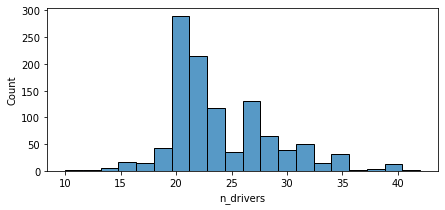

In [91]:
drivers_per_race = races.groupby(['raceId'])['Name'].nunique().reset_index(name='n_drivers')
fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(data=drivers_per_race,x='n_drivers',bins=20)

Text(0.5, 1.0, 'Number of Races By Maximum Number of Drivers')

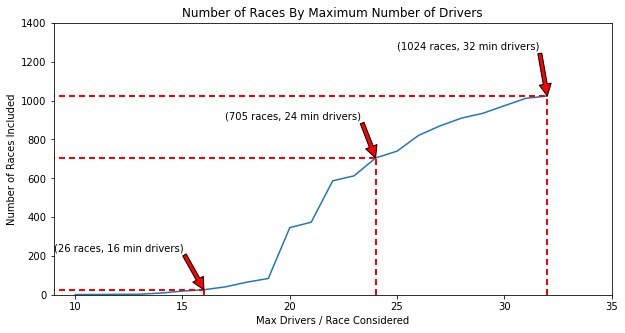

In [143]:
drivers_per_race = races.groupby(['raceId'])['Name'].nunique().reset_index(name='n_drivers')
n_races_n_drivers = drivers_per_race.groupby('n_drivers')['raceId'].nunique().reset_index(name='n_races')
n_races_n_drivers = n_races_n_drivers.sort_values(by='n_drivers', ascending=True)
n_races_n_drivers['cum_n_races'] = n_races_n_drivers['n_races'].cumsum()

fig,ax = plt.subplots(figsize=(10, 5))
lineplot = sns.lineplot(data=n_races_n_drivers, x='n_drivers',y='cum_n_races')
ax.set(xlabel='Max Drivers / Race Considered', ylabel='Number of Races Included')
plt.xlim(9,35)
plt.ylim(0,1400)

adj_x = [1, 3, 2]
adj_y = [200, 200, 240]

min_drvs_list = [16,24,32]
for min_drvs in min_drvs_list:

    cum_races = n_races_n_drivers.loc[n_races_n_drivers['n_drivers']==min_drvs, 'cum_n_races'].squeeze()
    
    ax.hlines(y=cum_races, xmin=0, xmax=min_drvs, linewidth=2, linestyle=linestyles['dashed'], color='r')
 
    ax.vlines(x=min_drvs, ymin=0, ymax=cum_races, linewidth=2, linestyle=linestyles['dashed'], color='r')
    ax.annotate('({} races, {} min drivers)'.format(cum_races, min_drvs), xy =(min_drvs, cum_races),
                        xytext =(min_drvs - 7, cum_races + adj_y.pop(0)), 
                     arrowprops = dict(facecolor ='r',
                                           shrink = 0.),)

plt.title('Number of Races By Maximum Number of Drivers')

In [135]:
# drivers_per_race = races.groupby(['raceId'])['Name'].nunique().reset_index(name='n_drivers')
# n_races_n_drivers = drivers_per_race.groupby('n_drivers')['raceId'].nunique().reset_index(name='n_races')
# n_races_n_drivers = n_races_n_drivers.sort_values(by='n_drivers', ascending=False)
# n_races_n_drivers['cum_n_races'] = n_races_n_drivers['n_races'].cumsum()

# fig,ax = plt.subplots()
# lineplot = sns.lineplot(data=n_races_n_drivers, x='n_drivers',y='cum_n_races')
# ax.set(xlabel='Minimum number of Drivers / Race', ylabel='Number of Races')
# plt.xlim(9,35)
# plt.ylim(0,1500)

# adj_x = [1, 3, 5, 2]
# adj_y = [240, 170, 100, 100]

# min_drvs_list = [10,15,20,30]
# for min_drvs in min_drvs_list:

#     cum_races = n_races_n_drivers.loc[n_races_n_drivers['n_drivers']==min_drvs, 'cum_n_races'].squeeze()
    
#     ax.hlines(y=cum_races, xmin=min(min_drvs_list), xmax=min_drvs, linewidth=2, linestyle=linestyles['dashed'], color='r')
 
#     if min_drvs != min(min_drvs_list):
#         ax.vlines(x=min_drvs, ymin=0, ymax=cum_races, linewidth=2, linestyle=linestyles['dashed'], color='r')
#     ax.annotate('({} races, {} min drivers)'.format(cum_races, min_drvs), xy =(min_drvs, cum_races),
#                         xytext =(min_drvs + adj_x.pop(0), cum_races + adj_y.pop(0)), 
#                      arrowprops = dict(facecolor ='r',
#                                            shrink = 0.),)

# plt.title('Number of Races By Minimum Number of Drivers Required For Modeling')

In [97]:
n_races_n_drivers

,n_drivers,n_races,cum_n_races
24,33,1,1
23,31,1,2
22,26,1,3
21,25,1,4
20,24,1,5
19,23,4,9
18,22,12,21
17,21,15,36
16,20,33,69
15,19,59,128


In [98]:
races_finished_only = races.copy(deep=True)
races_finished_only['position'] = races_finished_only['position'].astype(float)
races_finished_only = races_finished_only[races_finished_only['position'].notnull()].reset_index(drop=True)
drivers_per_race = races_finished_only.groupby(['raceId'])['Name'].nunique().reset_index(name='n_drivers')
n_races_n_drivers = drivers_per_race.groupby('n_drivers')['raceId'].nunique().reset_index(name='n_races')
n_races_n_drivers = n_races_n_drivers.sort_values(by='n_drivers', ascending=False)
n_races_n_drivers['cum_n_races'] = n_races_n_drivers['n_races'].cumsum()


In [104]:

# races_finished_only = races.copy(deep=True)
# races_finished_only['position'] = races_finished_only['position'].astype(float)
# races_finished_only = races_finished_only[races_finished_only['position'].notnull()].reset_index(drop=True)
# drivers_per_race = races_finished_only.groupby(['raceId'])['Name'].nunique().reset_index(name='n_drivers')
# n_races_n_drivers = drivers_per_race.groupby('n_drivers')['raceId'].nunique().reset_index(name='n_races')
# n_races_n_drivers = n_races_n_drivers.sort_values(by='n_drivers', ascending=False)
# n_races_n_drivers['cum_n_races'] = n_races_n_drivers['n_races'].cumsum()


# fig,ax = plt.subplots()
# lineplot = sns.lineplot(data=n_races_n_drivers, x='n_drivers',y='cum_n_races')
# ax.set(xlabel='Minimum number of Drivers / Race', ylabel='Number of Races')
# plt.xlim(9,35)
# plt.ylim(0,1500)

# adj_x = [1, 3, 5, 2]
# adj_y = [240, 170, 100, 100]

# min_drvs_list = [10,15,20]
# for min_drvs in min_drvs_list:

#     cum_races = n_races_n_drivers.loc[n_races_n_drivers['n_drivers']==min_drvs, 'cum_n_races'].squeeze()
    
#     ax.hlines(y=cum_races, xmin=min(min_drvs_list), xmax=min_drvs, linewidth=2, linestyle=linestyles['dashed'], color='r')
 
#     if min_drvs != min(min_drvs_list):
#         ax.vlines(x=min_drvs, ymin=0, ymax=cum_races, linewidth=2, linestyle=linestyles['dashed'], color='r')
#     ax.annotate('({} races, {} min drivers)'.format(cum_races, min_drvs), xy =(min_drvs, cum_races),
#                         xytext =(min_drvs + adj_x.pop(0), cum_races + adj_y.pop(0)), 
#                      arrowprops = dict(facecolor ='r',
#                                            shrink = 0.),)

# plt.title('Number of Races By Minimum Number of Drivers Required For Modeling (remove non-finishes)')